# 모델링

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

base_model = tf.keras.applications.InceptionV3(input_shape=[96, 96, 3], include_top=False, weights='imagenet')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 47, 47, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 47, 47, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 47, 47, 32)   0           ['batch_normalization_

## 저장한 배열이미지 데이터 불러오기

In [ ]:
dataset_label = np.load('./array/1124_tumor_indicator.npy')
dataset_patches_all = np.load('./array/1124_real_tumor_indicator.npy')

time: 1.39 s (started: 2022-11-25 11:34:50 +00:00)


In [ ]:
dataset_patches_all.shape

(144362, 32, 32, 3)

time: 4.74 ms (started: 2022-11-25 11:34:54 +00:00)


## 종양, 비종양 비율 맞춰서 진행

### 종양 여부에 따라 데이터 나누기

In [ ]:
pd.Series(dataset_label).value_counts()

0    128842
1     15520
dtype: int64

time: 70.8 ms (started: 2022-11-24 06:37:53 +00:00)


In [ ]:
patches_with_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 1])
patches_without_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 0])

time: 591 ms (started: 2022-11-25 11:34:57 +00:00)


In [ ]:
patches_with_tumor.shape, patches_without_tumor.shape

((15520, 32, 32, 3), (128842, 32, 32, 3))

time: 8.21 ms (started: 2022-11-24 06:38:30 +00:00)


### 패치 개수 맞춰주기

In [ ]:
# 종양 개수만큼 인덱싱해서 비종양 패치 추출
patches_without_tumor_set = patches_without_tumor[:len(patches_with_tumor)]

# 종양 및 비종양 패치 원본 배열 합치기
dataset_patches = np.array(patches_without_tumor_set.tolist() + patches_with_tumor.tolist())
# 종양 및 비종양 패치 레이블 배열 만들기
dataset_label = np.array(np.zeros(15520).tolist() + np.ones(15520).tolist())

# 확인
dataset_patches.shape, dataset_label.shape

((31040, 32, 32, 3), (31040,))

time: 46 s (started: 2022-11-24 06:44:59 +00:00)


In [ ]:
# 종양 부분  
plt.figure(figsize = (20,20))
for i in range(80,180):
  ax = plt.subplot(10, 10, i-80 + 1)
  plt.imshow(patches_with_tumor[i])

In [ ]:
# 비종양 부분
plt.figure(figsize = (20,20))
for i in range(80,180):
  ax = plt.subplot(10, 10, i-80 + 1)
  plt.imshow(patches_without_tumor[i])

### 훈련 및 테스트용 데이터 분리

In [ ]:
# 훈련/테스트용 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(dataset_patches, 
                                                  dataset_label, 
                                                  test_size=0.2, 
                                                  random_state=42)

# 정규화
X_train = (np.array(X_train).astype('float32') / 255.) * 2.0 - 1
X_val = (np.array(X_val).astype('float32') / 255.) * 2.0 - 1.0

# Check the split
print("Size of the train set: {:d}".format(len(y_train)))
print("Size of the validation set: {:d}".format(len(y_val)))
print("Size of the train data sample: " + str(X_train[0].shape))
print("Size of the validation data sample: " + str(X_val[0].shape))

Size of the train set: 24832
Size of the validation set: 6208
Size of the train data sample: (32, 32, 3)
Size of the validation data sample: (32, 32, 3)
time: 764 ms (started: 2022-11-24 06:47:32 +00:00)


### 모델링

In [ ]:
import keras

# Freeze all weights
base_model.trainable = False 

# Add input transpose conv layer
input_layer = tf.keras.layers.InputLayer(
    input_shape=[32, 32, 3])
input_tranConv = tf.keras.layers.Conv2DTranspose(3, [3, 3], 
                                                 strides=3,
                                                 padding='same',
                                                 use_bias=False)

# Add last layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build a new model reusing the pretrained base
model = tf.keras.Sequential([
                              input_layer,
                              input_tranConv,                           
                              base_model,
                              global_average_layer,
                              prediction_layer
])

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 50, 
                                                  restore_best_weights = True, 
                                                  monitor = 'val_loss')
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 679 ms (started: 2022-11-24 06:58:35 +00:00)


In [ ]:
# Check the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2DT  (None, 96, 96, 3)        81        
 ranspose)                                                       
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,914
Trainable params: 2,130
Non-trainable params: 21,802,784
_________________________________________________________________
time: 55.4 ms (started: 2022-11-24 06:

### 학습

In [ ]:
# 모델 저장을 위한 경로 지정
drive_root = './'
checkpoint_dir = os.path.join(drive_root, "Checkpoints", "InceptionV3-Freeze40-UnbalData")


# Checkpoints 폴더가 없으면 생성하기
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


# Checkpoints 폴더 내 best_params 모델 저장
checkpoint_path = os.path.join(checkpoint_dir, "1124_tumor_best_model.hdf5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                          filepath = checkpoint_path, 
                                                          monitor = 'val_loss',  
                                                             ## val_loss로 모델의 best를 판단
                                                          verbose = 0, 
                                                          save_best_only = True,
                                                             ## True: monitor 되고 있는 값을 기준 베스트 모델만 저장
                                                             ## False: 모든 epoch마다 모델 저장
                                                          save_weights_only = False, 
                                                             ## True: 모델 weights만 저장
                                                             ## false:모델 레이어 및 weights 모두 저장
                                                          mode = 'auto')
                                                             ## max: 보통 moniter값이 val_acc인 경우 사용
                                                             ## min: 보통 moniter값이 val_loss인 경우 사용
                                                             ## auto: 모델이 알아서 min, max를 판단 

Checkpoints directory is ./Checkpoints/InceptionV3-Freeze40-UnbalData
Checkpoints folder already exists
time: 6.01 ms (started: 2022-11-24 06:58:46 +00:00)


In [ ]:
# Train the first and last layer first
EPOCH = 200
BATCH_SIZE = 512
y_train = np.array(y_train)
y_val = np.array(y_val)
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = EPOCH, 
                    # callbacks = [early_stopping_cb], 
                    callbacks = [checkpoint_callback, early_stopping_cb],
                    batch_size = BATCH_SIZE)

Epoch 1/200
49/49 [==============================] - 29s 488ms/step - loss: 0.7047 - accuracy: 0.6123 - val_loss: 0.6193 - val_accuracy: 0.6567
Epoch 2/200
49/49 [==============================] - 24s 495ms/step - loss: 0.6018 - accuracy: 0.6647 - val_loss: 0.6050 - val_accuracy: 0.6614
Epoch 3/200
49/49 [==============================] - 24s 483ms/step - loss: 0.5885 - accuracy: 0.6738 - val_loss: 0.6009 - val_accuracy: 0.6653
Epoch 4/200
49/49 [==============================] - 22s 441ms/step - loss: 0.5791 - accuracy: 0.6802 - val_loss: 0.6277 - val_accuracy: 0.6516
Epoch 5/200
49/49 [==============================] - 22s 456ms/step - loss: 0.5776 - accuracy: 0.6832 - val_loss: 0.5921 - val_accuracy: 0.6775
Epoch 6/200
49/49 [==============================] - 22s 457ms/step - loss: 0.5774 - accuracy: 0.6817 - val_loss: 0.5885 - val_accuracy: 0.6662
Epoch 7/200
49/49 [==============================] - 22s 454ms/step - loss: 0.5685 - accuracy: 0.6887 - val_loss: 0.5836 - val_accuracy:

In [ ]:
# 해당 모델의 레이어의 파라미터를 학습 과정(back propagation) 중 파라미터 최적화를 수행하지 않겠다는 의미
layer_freeze = "mixed0"

for index, layer in enumerate(base_model.layers):
    if layer.name == layer_freeze:
        print(str(index) + ":" + str(layer.name))

40:mixed0
time: 1.41 ms (started: 2022-11-23 09:23:05 +00:00)


In [ ]:
# freeze 시킨 layer까지 가중치 학습(파라미터 최적화)하지않고 그 이후로는 학습하여 최적화하도록함
model.trainable = True

max_layer_freeze = 40

for layer in base_model.layers[:max_layer_freeze]:
  layer.trainable = False

time: 13.7 ms (started: 2022-11-23 09:23:05 +00:00)


In [ ]:
# Make checkpoint
drive_root = './'
checkpoint_dir = os.path.join(drive_root, "Checkpoints", "InceptionV3-Freeze40-UnbalData")

# Create checkpoint folder
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

# Make checkpoint callbacks
checkpoint_path = os.path.join(checkpoint_dir, "1124_generator_tumor_best_model.hdf5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True,
                    save_weights_only=False, mode='auto')

Checkpoints directory is ./Checkpoints/InceptionV3-Freeze40-UnbalData
Checkpoints folder already exists
time: 2.25 ms (started: 2022-11-23 09:23:05 +00:00)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 증식을 위한 제너레이터 생성
train_datagen = ImageDataGenerator(
                                    shear_range=0.2,    
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,  
                                    horizontal_flip=True,
                                    vertical_flip=True)

train_datagen.fit(X_train)

# Note that the validation data should not be augmented!
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE)

time: 1.51 s (started: 2022-11-23 09:23:05 +00:00)


In [ ]:
# Recompile the model (to set lr after initial training on 1 batch)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the whole model again
EPOCH = 200
history = model.fit(
      train_generator,
      steps_per_epoch = X_train.shape[0] / BATCH_SIZE,
      epochs = EPOCH,
      validation_data = (X_val, y_val), 
      callbacks=[checkpoint_callback, early_stopping_cb])   

Epoch 1/200
225/225 [==============================] - 146s 609ms/step - loss: 0.1541 - accuracy: 0.9663 - val_loss: 0.1463 - val_accuracy: 0.9655
Epoch 2/200
225/225 [==============================] - 129s 572ms/step - loss: 0.1425 - accuracy: 0.9669 - val_loss: 0.1461 - val_accuracy: 0.9655
Epoch 3/200
225/225 [==============================] - 129s 571ms/step - loss: 0.1405 - accuracy: 0.9669 - val_loss: 0.1446 - val_accuracy: 0.9655
Epoch 4/200
225/225 [==============================] - 131s 580ms/step - loss: 0.1398 - accuracy: 0.9669 - val_loss: 0.1472 - val_accuracy: 0.9655
Epoch 5/200
225/225 [==============================] - 129s 571ms/step - loss: 0.1395 - accuracy: 0.9669 - val_loss: 0.1437 - val_accuracy: 0.9655
Epoch 6/200
225/225 [==============================] - 131s 579ms/step - loss: 0.1384 - accuracy: 0.9669 - val_loss: 0.1443 - val_accuracy: 0.9655
Epoch 7/200
225/225 [==============================] - 131s 579ms/step - loss: 0.1382 - accuracy: 0.9669 - val_loss: 0

### 시각화

In [ ]:
# Function to plot the history of training
def plot_training(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot the result
  epochs = range(len(acc))
  fig = plt.figure(figsize=(15, 5))
  ax1 = fig.add_subplot(121)
  plt.title('Max val accuracy: {0:.4f}'.format(max(val_acc)))
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  ax1 = fig.add_subplot(122)
  plt.title('Min val loss: {0:.4f}'.format(min(val_loss)))
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  if max(val_loss) > 3:
      plt.ylim(0, 3)

  # Save the figure
  path = fig_save_path + ".png"
  plt.tight_layout()
  plt.savefig(path, format="png", dpi=300)

In [ ]:
# Plot the history of training
fig_save_path = "./models/1122_InceptionV3_method3"
plot_training(history)

### 저장하기

In [ ]:
model.save('./models/1122_image_inceptionv3_method3.h5')

### 모델 불러오기

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./models/1121_image_inceptionv3_method3.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 96, 96, 3)        81        
 nspose)                                                         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,914
Trainable params: 21,342,770
Non-trainable params: 462,144
_________________________________________________________________
time: 4.52 s (started: 2022-11-22 06:3

## 저장한 배열이미지 데이터 불러오기

In [ ]:
dataset_label = np.load('./array/1124_tumor_indicator.npy')
dataset_patches_all = np.load('./array/1124_real_tumor_indicator.npy')

time: 4.17 s (started: 2022-11-25 11:21:06 +00:00)


In [ ]:
dataset_patches_all.shape

(144362, 32, 32, 3)

time: 3.84 ms (started: 2022-11-24 08:58:41 +00:00)


## 종양, 비종양 비율 맞추지 않고 진행

### 종양 여부에 따라 데이터 나누기

In [ ]:
pd.Series(dataset_label).value_counts()

0    128842
1     15520
dtype: int64

time: 9.69 ms (started: 2022-11-24 08:58:46 +00:00)


In [ ]:
patches_with_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 1])
patches_without_tumor = np.array([dataset_patches_all[ind, :, :] for ind in range(len(dataset_label)) if dataset_label[ind] == 0])

time: 358 ms (started: 2022-11-24 08:58:48 +00:00)


In [ ]:
patches_with_tumor.shape, patches_without_tumor.shape

((15520, 32, 32, 3), (128842, 32, 32, 3))

time: 3.97 ms (started: 2022-11-24 08:58:50 +00:00)


### 패치 개수 맞춰주기

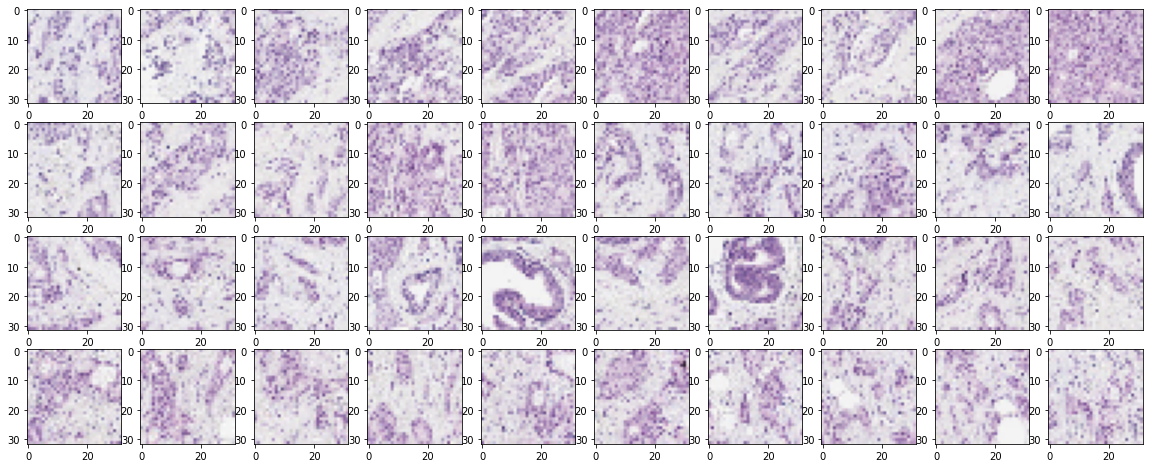

time: 3.83 s (started: 2022-11-24 08:58:52 +00:00)


In [ ]:
# 종양 부분  
plt.figure(figsize = (20,8))
for i in range(40):
  ax = plt.subplot(4, 10, i + 1)
  plt.imshow(patches_with_tumor[i])

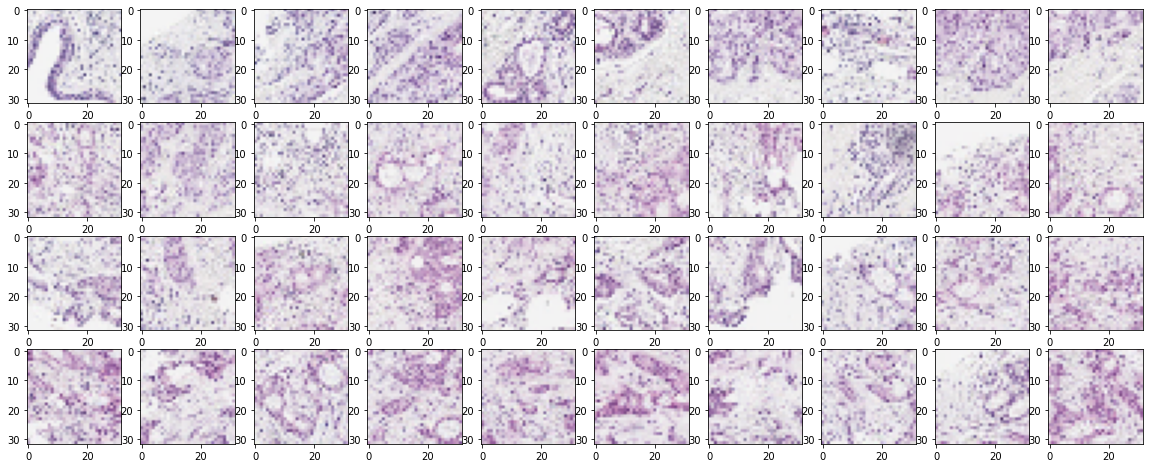

time: 3.81 s (started: 2022-11-24 08:59:00 +00:00)


In [ ]:
# 비종양 부분
plt.figure(figsize = (20,8))
for i in range(40):
  ax = plt.subplot(4, 10, i + 1)
  plt.imshow(patches_without_tumor[i])

### 훈련 및 테스트용 데이터 분리

In [ ]:
# 훈련/테스트용 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(dataset_patches_all, 
                                                  dataset_label, 
                                                  test_size=0.25, 
                                                  random_state=43)

# 정규화
X_train = (np.array(X_train).astype('float32') / 255.) * 2.0 - 1
X_val = (np.array(X_val).astype('float32') / 255.) * 2.0 - 1.0

# Check the split
print("Size of the train set: {:d}".format(len(y_train)))
print("Size of the validation set: {:d}".format(len(y_val)))
print("Size of the train data sample: " + str(X_train[0].shape))
print("Size of the validation data sample: " + str(X_val[0].shape))

Size of the train set: 108271
Size of the validation set: 36091
Size of the train data sample: (32, 32, 3)
Size of the validation data sample: (32, 32, 3)
time: 1.55 s (started: 2022-11-25 10:28:15 +00:00)


### 모델링

In [ ]:
import keras

# Freeze all weights
base_model.trainable = False 

# Add input transpose conv layer
input_layer = tf.keras.layers.InputLayer(
    input_shape=[32, 32, 3])
input_tranConv = tf.keras.layers.Conv2DTranspose(3, [3, 3], 
                                                 strides=3,
                                                 padding='same',
                                                 use_bias=False)

# Add last layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build a new model reusing the pretrained base
model = tf.keras.Sequential([
                              input_layer,
                              input_tranConv,                           
                              base_model,
                              global_average_layer,
                              prediction_layer
])

# Compile the model
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 50, 
                                                  restore_best_weights = True, 
                                                  monitor = 'val_loss')
optimizer = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 715 ms (started: 2022-11-24 09:00:37 +00:00)


In [ ]:
# Check the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_4 (Conv2DT  (None, 96, 96, 3)        81        
 ranspose)                                                       
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,914
Trainable params: 2,130
Non-trainable params: 21,802,784
_________________________________________________________________
time: 54.8 ms (started: 2022-11-24 09:

### 학습

In [ ]:
# 모델 저장을 위한 경로 지정
drive_root = './'
checkpoint_dir = os.path.join(drive_root, "Checkpoints", "InceptionV3-Freeze40-UnbalData")


# Checkpoints 폴더가 없으면 생성하기
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


# Checkpoints 폴더 내 best_params 모델 저장
checkpoint_path = os.path.join(checkpoint_dir, "1124_all_tumor_best_model.hdf5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                          filepath = checkpoint_path, 
                                                          monitor = 'val_loss',  
                                                             ## val_loss로 모델의 best를 판단
                                                          verbose = 0, 
                                                          save_best_only = True,
                                                             ## True: monitor 되고 있는 값을 기준 베스트 모델만 저장
                                                             ## False: 모든 epoch마다 모델 저장
                                                          save_weights_only = False, 
                                                             ## True: 모델 weights만 저장
                                                             ## false:모델 레이어 및 weights 모두 저장
                                                          mode = 'auto')
                                                             ## max: 보통 moniter값이 val_acc인 경우 사용
                                                             ## min: 보통 moniter값이 val_loss인 경우 사용
                                                             ## auto: 모델이 알아서 min, max를 판단 

Checkpoints directory is ./Checkpoints/InceptionV3-Freeze40-UnbalData
Checkpoints folder already exists
time: 8.45 ms (started: 2022-11-25 10:05:25 +00:00)


In [ ]:
# Train the first and last layer first
EPOCH = 200
BATCH_SIZE = 512
y_train = np.array(y_train)
y_val = np.array(y_val)
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = EPOCH, 
                    # callbacks = [early_stopping_cb], 
                    callbacks = [checkpoint_callback, early_stopping_cb],
                    batch_size = BATCH_SIZE)

Epoch 1/200
212/212 [==============================] - 117s 480ms/step - loss: 0.3431 - accuracy: 0.8877 - val_loss: 0.3252 - val_accuracy: 0.8952
Epoch 2/200
212/212 [==============================] - 92s 433ms/step - loss: 0.3230 - accuracy: 0.8915 - val_loss: 0.3263 - val_accuracy: 0.8947
Epoch 3/200
212/212 [==============================] - 94s 445ms/step - loss: 0.3224 - accuracy: 0.8913 - val_loss: 0.3247 - val_accuracy: 0.8951
Epoch 4/200
212/212 [==============================] - 93s 440ms/step - loss: 0.3201 - accuracy: 0.8915 - val_loss: 0.3180 - val_accuracy: 0.8946
Epoch 5/200
212/212 [==============================] - 93s 440ms/step - loss: 0.3203 - accuracy: 0.8915 - val_loss: 0.3169 - val_accuracy: 0.8953
Epoch 6/200
212/212 [==============================] - 92s 432ms/step - loss: 0.3206 - accuracy: 0.8914 - val_loss: 0.3254 - val_accuracy: 0.8948
Epoch 7/200
212/212 [==============================] - 92s 433ms/step - loss: 0.3218 - accuracy: 0.8912 - val_loss: 0.3196 

# 예측 TEST

### 패치데이터 불러오기

In [ ]:
train_patches = np.load('./array/1121_real_invasive_indicator_train_2개.npy', allow_pickle= True)
train_patches

In [ ]:
train_patches[0][0].shape

(32, 32, 3)

time: 3.77 ms (started: 2022-11-22 06:37:37 +00:00)


In [ ]:
for i in range(2):
  print(f'***patch{i+1}번째')
  invasive = 0
  non_invasive = 0
  for patch in train_patches[i]:
    patch = (patch.astype('float32') / 255.) * 2.0 - 1
    preds = model.predict(patch[None,:], verbose = 0)
    
    if preds > 0.5:
      invasive += 1
    else:
      non_invasive += 1
    
  print(f'invasive 개수: {invasive}')
  print(f'non_invasive 개수: {non_invasive}')

***patch1번째
invasive 개수: 3981
non_invasive 개수: 90
***patch2번째
invasive 개수: 2440
non_invasive 개수: 9
time: 6min 52s (started: 2022-11-22 06:51:32 +00:00)
